## Yosemite Village yearly weather

#### Raymundo Gonzalez Leal

The data used here comes from the U.S. Climate Reference Network / U.S. Regional Climate Reference Network (USCRN/USRCRN), and can be accessed at:

ftp://ftp.ncdc.noaa.gov/pub/data/uscrn/products/subhourly01

In this project I'll attempt to predict temperature and rain in the Yosemite Village.

### Imports and data prep

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.pyplot as plt

%matplotlib notebook


#import antigravity

In [158]:
train_years = range(2014,2016)
files = ['CRNS0101-05-%d-CA_Yosemite_Village_12_W.txt' % y for y in train_years]
usecols = [1, 2, 8, 9]

data_train = [np.loadtxt(f, usecols=usecols) for f in files]
data_train = np.vstack(data_train)
# Map from HHmm to an integer
data_train[:, 1] = np.floor_divide(data_train[:, 1], 100) * 60 + np.mod(data_train[:, 1], 100)

valid_train = data_train[:, 2] > -1000
x_minutes_train = data_train[valid_train, 1].reshape(-1, 1)
y_train = data_train[valid_train, 2]

In [3]:
val_years = range(2016,2017)
files = ['CRNS0101-05-%d-CA_Yosemite_Village_12_W.txt' % y for y in val_years]

data_val = [np.loadtxt(f, usecols=usecols) for f in files]
data_val = np.vstack(data_val)
# Map from HHmm to an integer
data_val[:, 1] = np.floor_divide(data_val[:, 1], 100) * 60 + np.mod(data_val[:, 1], 100)
valid_val = data_val[:, 2] > -1000

x_minutes_val = data_val[valid_val, 1].reshape(-1, 1)
y_val = data_val[valid_val, 2]

In [ ]:
#Let's use the month as another variable
X_train = []
x_date_train = []

for i in range(len(x_minutes_train)):
    
    date = data_train[valid_train,0][i]
    month = np.floor_divide(date,100)   
    day = date - month*100
    year = np.floor_divide(date,10000)
    month = month - year*100  
    day = (month-1)*30 + day
       
    this_val = np.append(x_minutes_train[i],day)
    X_train.append(this_val)
    x_date_train.append([day])

In [5]:
X_val = []
x_date_val = []

for i in range(len(x_minutes_val)):
    
    date = data_val[valid_val,0][i]
    month = np.floor_divide(date,100)   
    day = date - month*100
    year = np.floor_divide(date,10000)
    month = month - year*100  
    day = (month-1)*30 + day
       
    this_val = np.append(x_minutes_val[i],day)
    X_val.append(this_val)
    x_date_val.append([day])

In [6]:
x_date_train = np.asarray(x_date_train)
x_date_val = np.asarray(x_date_val)

### Exploring our data

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


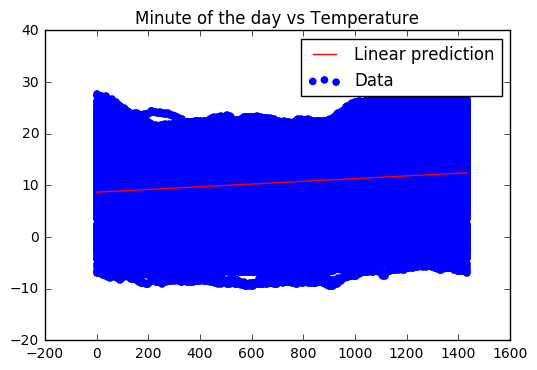

In [7]:
regr = linear_model.LinearRegression()
regr.fit(x_minutes_train, y_train)

x_mins_pred = [[0], [1435]]
y_predict = regr.predict(x_mins_pred)

plt.scatter(data_train[valid_train, 1], data_train[valid_train, 2], label='Data', color='b')
plt.plot(x_mins_pred, y_predict, label='Linear prediction', color='r')
plt.legend(loc='best')
plt.title("Minute of the day vs Temperature")
plt.show()

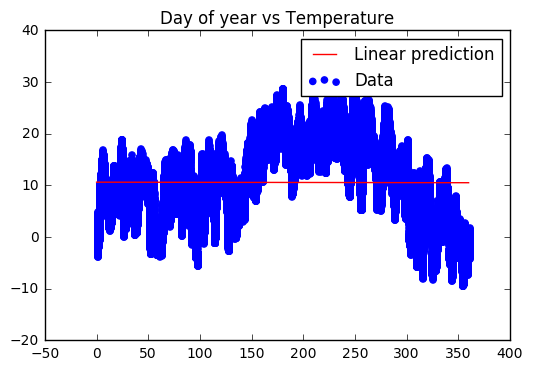

In [8]:
regr = linear_model.LinearRegression()
regr.fit(x_date_train, y_train)

plt.scatter(x_date_train, data_train[valid_train, 2], label='Data', color='b')
x_day_pred = [[0], [360]]
y_predict = regr.predict(x_day_pred)
plt.plot(x_day_pred, y_predict, label='Linear prediction', color='r')
plt.legend(loc='best')
plt.title("Day of year vs Temperature")
plt.show()

Clearly there is some useful relationship between day of year and temperature. Minute of the day seems to explain less of the variance in temperature (We have a lot of variation for the same minute), but still some relationship is noticeable. However, it is also clear that these relationships are not linear, and using a linear model will not get us very far (notice how in both of our graphs, especially in the second one, the slope of the linear regression is quite close to 0). 

In [157]:
# Fit using only minute of the day
regr.fit(x_minutes_train, y_train)
y_pred = regr.predict(x_minutes_train)
mse(y_train,y_pred)
print "MSE on training data using minute of day: ", mse(y_train,y_pred)

MSE on training data using minute of day:  55.9177272794


In [155]:
# Fit using only day
regr.fit(x_date_train, y_train)
y_pred = regr.predict(x_date_train)
print "MSE on training data using day of year: ",mse(y_train,y_pred)

MSE on training data using day of year:  57.0987569055


In [156]:
#Fit using day of the year and minute of the day
regr.fit(X_train, y_train)
y_pred = regr.predict(X_train)
print "MSE on training data using both predictors: ", mse(y_train,y_pred)

MSE on training data using both predictors:  55.9167588116


### Using radial basis functions

In [13]:
def rbf(x,mu,sigma):
    ans = []
    for i in range(len(x)):
        thisZ = (x[i]-mu)/sigma
        ans.append(np.exp(-thisZ[0]**2))
    return ans

In [14]:
def Make_rbfs(x,sigma,max_value,n):
    rbf_list = []
    for mu in range(max_value/(n+1),max_value,max_value/(n+1)):
        this_rbf = rbf(x,mu,sigma)
        rbf_list.append(this_rbf)
    
    X_rbfs = [[] for i in range(len(x))]
    
    for i in range(len(x)):
        for this_rbf in rbf_list:
            X_rbfs[i].append(this_rbf[i])
        
    #return rbf_list
    return X_rbfs

#### Time of day model

Now I will try to find the optimal number of radial basis functions to use for a model that takes the minute of the day as it's sole predictor.

Because we are evenly spreading our rbf means. It seems reasonable that we will change our sigma depending on the number of radial basis functions (a small sigma that would result in many points having a value of 0 if we have very few rbfs can be appropriate when we have many functions). Hence I will modify sigma depending on my number of rbfs, such that any point is at most 2 standard deviations away from it's nearest rbf mean. We could also cross validate so that we find the best sigma to use for every number of rbfs. However, this seems to be a reasonable approach if we don't have the time to do that extensive search.

In [15]:
n_rbfs = [i for i in range(1,30,3)]
train_mse_list = []
val_mse_list = []

for n in n_rbfs:
    X_min_rbfs_train = Make_rbfs(x_minutes_train, sigma = 1440.0 /((n+1)/2) , max_value= 1440, n = n)
    X_min_rbfs_val = Make_rbfs(x_minutes_val, sigma = 1440.0 /((n+1)/2) , max_value= 1440, n = n)
    regr.fit(X_min_rbfs_train, y_train)
    y_pred_train = regr.predict(X_min_rbfs_train)
    y_pred_val = regr.predict(X_min_rbfs_val)
    train_mse_list.append(mse(y_train,y_pred_train))
    val_mse_list.append(mse(y_val,y_pred_val))
    

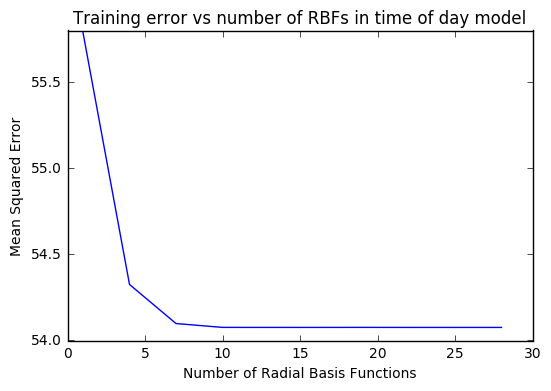

In [35]:
plt.plot(n_rbfs,train_mse_list)
plt.xlabel("Number of Radial Basis Functions")
plt.title("Training error vs number of RBFs in time of day model")
plt.ylabel("Mean Squared Error")
plt.show()

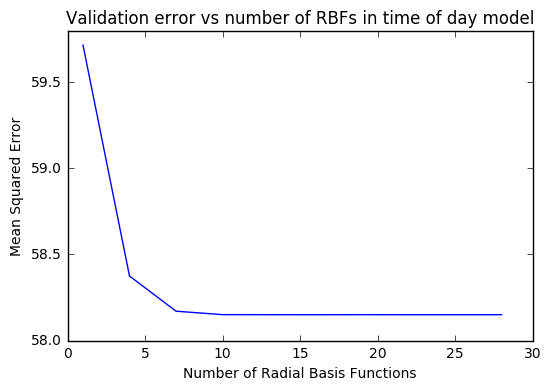

In [36]:
plt.plot(n_rbfs,val_mse_list)
plt.xlabel("Number of Radial Basis Functions")
plt.title("Validation error vs number of RBFs in time of day model")
plt.ylabel("Mean Squared Error")
plt.show()

I know what you are thinking, the two graphs above look suspiciously similar, like there is a bug and I actually just plotted the same data twice. Nope! look at the Y axis, our validation error is in general larger than our training error (even though both errors have a shared behaviour with the number of rbfs)

### Day of year model

Now let's try the same, but with a model that uses only day of the year as a predictor

In [60]:
n_rbfs = [i for i in range(1,17,1)]
train_mse_list = []
val_mse_list = []

for n in n_rbfs:
    X_date_rbfs_train = Make_rbfs(x_date_train, sigma = 365.0 /((n+1)/2) , max_value= 365, n = n)
    X_date_rbfs_val = Make_rbfs(x_date_val, sigma = 365.0 /((n+1)/2) , max_value= 365, n = n)

    regr.fit(X_date_rbfs_train, y_train)
    
    y_pred_train = regr.predict(X_date_rbfs_train)
    y_pred_val = regr.predict(X_date_rbfs_val)
    train_mse_list.append(mse(y_train,y_pred_train))
    val_mse_list.append(mse(y_val,y_pred_val))

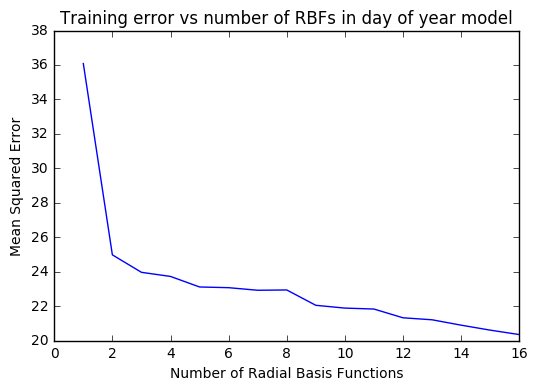

In [61]:
plt.plot(n_rbfs,train_mse_list)
plt.xlabel("Number of Radial Basis Functions")
plt.title("Training error vs number of RBFs in day of year model")
plt.ylabel("Mean Squared Error")
plt.show()

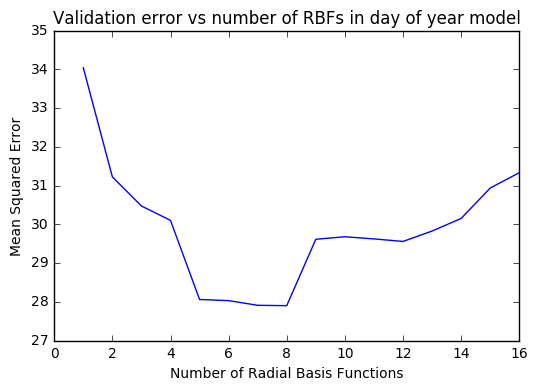

In [62]:
plt.plot(n_rbfs,val_mse_list)
plt.xlabel("Number of Radial Basis Functions")
plt.title("Validation error vs number of RBFs in day of year model")
plt.ylabel("Mean Squared Error")
plt.show()

### Combined model

Por que no los dos? Let's try using a model that makes predictions using the both rbfs for day of year and time of day. Note that we are treating these variables independently (applying rbfs for each variables and combining the results in a vector). A more sensitive approach may be applying rbfs on the combined data, evenly spreading our centers accross our time of day / day of year plane. After all, time of day and day of year don't seem to affect temperature in an independent manner (days are longer in some seasons, for instance). The problem is the curse of dimensionality. If we treat our variables independently and we want to use 10 centers for each variable, then the combined model would be using 20 variables. If instead of treating them independently we want to evently spread our points accross the plane, obtaining the same level of resolution (how much we divide our variable in centers) in the plane that we would have on a single variable, we would need to use 100 centers (imagine filling a floor with tiles). 

Due to time constraints, I will treat my variables independently, but I would recommend to extend this work by using 2 dimensional centers for the rbf functions, and cross validating the number of centers in the combined function, rather than just doing this cross validation for each variable independently (like I did here).

<IPython.core.display.Javascript object>


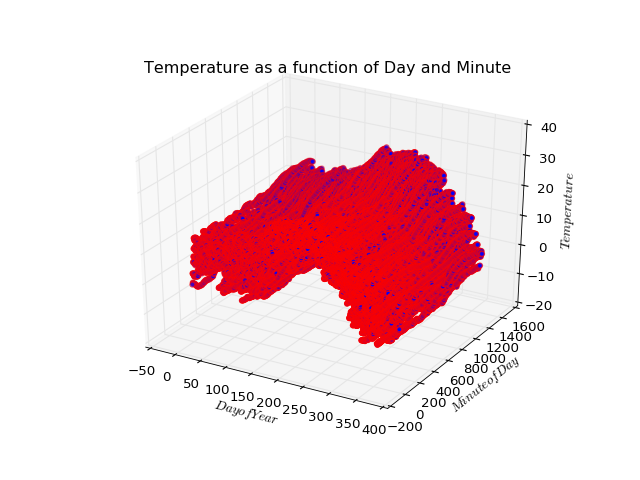

In [84]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_date_train, x_minutes_train, y_train, color = 'red')
ax.set_xlabel('$Day of Year$')
ax.set_ylabel('$Minute of Day$')
ax.set_zlabel('$Temperature$')
plt.title("Temperature as a function of Day and Minute")

In [96]:
X_date_rbfs_train = Make_rbfs(x_date_train, 
                              sigma = 365.0 /((7+1)/2) , max_value= 365, n = 7)
X_min_rbfs_train = Make_rbfs(x_minutes_train, 
                             sigma = 1440.0 /((10+1)/2) , max_value= 1440, n = 10)

X_date_rbfs_val = Make_rbfs(x_date_val,
                            sigma = 365.0 /((7+1)/2) , max_value= 365, n = 7)
X_min_rbfs_val = Make_rbfs(x_minutes_val, 
                           sigma = 1440.0 /((10+1)/2) , max_value= 1440, n = 10)

In [105]:
X_date_rbfs_train = np.asarray(X_date_rbfs_train)
X_min_rbfs_train = np.asarray(X_min_rbfs_train)
X_rbfs_train = np.hstack((X_date_rbfs_train,X_min_rbfs_train))

X_rbfs_val = []
X_date_rbfs_val = np.asarray(X_date_rbfs_val)
X_min_rbfs_val = np.asarray(X_min_rbfs_val)
X_rbfs_val = np.hstack((X_date_rbfs_val,X_min_rbfs_val))

In [109]:
regr.fit(X_rbfs_train, y_train)
y_pred = regr.predict(X_rbfs_train)
print "Training MSE: ", mse(y_train,y_pred)

y_pred = regr.predict(X_rbfs_val)
print "Validation MSE: ", mse(y_val,y_pred)

Training MSE:  19.890187101
Validation MSE:  25.2267091745


Our validation MSE is about 25, which means that the average difference between our temperature predictions and the real temperatures is 5C (of course, we don't know how the distribution really looks like, so maybe we are really wrong in some predictions).  Given that we are predicting the temperature for any minute at any day, and we are using no more information than those variables, this model actually doesn't seem that bad.

## Yosemite Village rain

In [55]:
rain_min_train = data_train[:,3].reshape(-1, 1)
rain_min_val = data_val[:,3].reshape(-1, 1)

I looked at the data and notice the following: For every year, the first day has it's first measurement on minute 5. After that, every day has it's first measurement on minute 0. The last measurement actually corresponds to the next year (new year's eve at midnight). There are 1440 minutes in every day, we measure every 5 minutes. Hence the first 287 measurements correspond to day 1, and after that every 288 measurements correspond to every other day.

In [70]:
rain_day_train = []
y_rain_train = []
rain_day_val = []
y_rain_val = []

day = 0
rain = 0

for i in range(len(rain_min_train)):
    if rain_min_train[i]>0: 
        rain = 1
    if i>288*day:
        y_rain_train.append(rain)
        rain_day_train.append([day%365+1])
        rain = 0
        day+=1
        
day = 0
rain = 0

for i in range(len(rain_min_val)):
    if rain_min_val[i]>0: 
        rain = 1
    if i>288*day:
        y_rain_val.append(rain)
        rain_day_val.append([day%365+1])
        rain = 0
        day+=1
        
ray_day_train  = np.asarray(rain_day_train).reshape(-1,1)
ray_day_val  = np.asarray(rain_day_val).reshape(-1,1)

In [57]:
clf = LogisticRegression()
clf.fit(rain_day_train,y_rain_train)

y_pred = clf.predict(rain_day_train)
print "Results on training data"
print metrics.classification_report(y_rain_train,y_pred)
print metrics.accuracy_score(y_rain_train,y_pred)

y_pred = clf.predict(rain_day_val)
print "Results on validation data"
print metrics.classification_report(y_rain_val,y_pred)
print metrics.accuracy_score(y_rain_val,y_pred)

Results on training data
             precision    recall  f1-score   support

          0       0.79      1.00      0.89       290
          1       0.00      0.00      0.00        75

avg / total       0.63      0.79      0.70       365

0.794520547945
Results on validation data
             precision    recall  f1-score   support

          0       0.76      1.00      0.86       277
          1       0.00      0.00      0.00        89

avg / total       0.57      0.76      0.65       366

0.756830601093


From the perfect recall of the 0 category, we see that the model based only on day of the year (whithout using rbfs) predicts that it won't rain any day. In Yosemite this is not too far from the truth, as the model obtained 0.79 accuracy in training data and 0.75 in validation. Despite how much we would enjoy to say that it simply never rains in California, it would be lame to not come up with a better model.

Will radial basis functions save us?

In [74]:
rain_day_train = np.asarray(rain_day_train)
rain_day_val = np.asarray(rain_day_val)

In [147]:
#This may look silly as our Xs will be the same if we have just 1 year for training and 1 for validation.
#However, treating our X_date separately for training and validation makes this robust to using multiple years for
#training.
n = 200
X_date_rbfs_train = Make_rbfs(rain_day_train, 
                              sigma = 365.0 /((n+1)/2) , max_value= 365, n = n)
X_date_rbfs_val = Make_rbfs(rain_day_val,
                            sigma = 365.0 /((n+1)/2) , max_value= 365, n = n)

In [148]:
clf.fit(X_date_rbfs_train,y_rain_train)

y_pred = clf.predict(X_date_rbfs_train)
print "Results on training data"
print metrics.classification_report(y_rain_train,y_pred)
print metrics.accuracy_score(y_rain_train,y_pred)

y_pred = clf.predict(X_date_rbfs_val)
print "Results on validation data"
print metrics.classification_report(y_rain_val,y_pred)
print metrics.accuracy_score(y_rain_val,y_pred)

Results on training data
             precision    recall  f1-score   support

          0       0.90      0.99      0.94       290
          1       0.93      0.57      0.71        75

avg / total       0.91      0.90      0.89       365

0.904109589041
Results on validation data
             precision    recall  f1-score   support

          0       0.77      0.89      0.83       277
          1       0.35      0.18      0.24        89

avg / total       0.67      0.72      0.68       366

0.718579234973


I tried using different numbers of centers (rbfs). If I didn't use many centers, the model kept prediciting that it would not rain any day. If I used many rbfs, overfitting became a problem, as my training results kept getting better but validation accuracy hindered (as seen in the results above using 300 centers). No number of centers resulted in a better validation accuracy than using no rbfs. Using a large amount of centers our validation accuracy diminishes, although at least now we have some recall for rainy days (but this is still quite worse than random guessing). 

Seems like we'll not get far using only day of the year as a predictor for rain. Hence, let's use other predictors as well. It is not clear which variables from our data we should use as predictors. For instance, the readme file from our data states that wetness is "The presence or absence of moisture due to precipitation". Hence, wetness would be a really good predictor for rain. But, does it make sense to predict wheter it is raining or not at some point using wetness at that moment as a predictor? That doesn't seem too different from using our outcome as our predictor itself.

In [119]:
#We'll assume that it never rains on January 1st
rain_yesterday_train = [[0]]
rain_yesterday_val = [[0]]

for i in y_rain_train[:-1]:
    rain_yesterday_train.append([i])

for i in y_rain_val[:-1]:
    rain_yesterday_val.append([i])

rain_yesterday_train = np.asarray(rain_yesterday_train)
rain_yesterday_val = np.asarray(rain_yesterday_val)

In [121]:
clf.fit(rain_yesterday_train, y_rain_train)

y_pred = clf.predict(rain_yesterday_train)
print "Results on training data"
print metrics.classification_report(y_rain_train,y_pred)
print metrics.accuracy_score(y_rain_train,y_pred)

Results on training data
             precision    recall  f1-score   support

          0       0.90      0.90      0.90       290
          1       0.60      0.60      0.60        75

avg / total       0.84      0.84      0.84       365

0.835616438356


In [123]:
y_pred = clf.predict(rain_yesterday_val)
print "Results on training data"
print metrics.classification_report(y_rain_val,y_pred)
print metrics.accuracy_score(y_rain_val,y_pred)

Results on training data
             precision    recall  f1-score   support

          0       0.88      0.88      0.88       277
          1       0.64      0.64      0.64        89

avg / total       0.83      0.83      0.83       366

0.825136612022


Looks like a decent predictor for rain on any day is wether it rained the day before. The model is not great at precision and recall for rain (which makes sense due to class imbalance) but at least it's better than random guessing.

In [137]:
X_train= np.hstack((rain_yesterday_train, rain_day_train))
X_val= np.hstack((rain_yesterday_val, rain_day_val))

In [132]:
clf.fit(X_train,y_rain_train)

y_pred = clf.predict(X_train)
print "Results on training data"
print metrics.classification_report(y_rain_train,y_pred)
print metrics.accuracy_score(y_rain_train,y_pred)

Results on training data
             precision    recall  f1-score   support

          0       0.90      0.90      0.90       290
          1       0.60      0.60      0.60        75

avg / total       0.84      0.84      0.84       365

0.835616438356


In [138]:
y_pred = clf.predict(X_val)
print "Results on training data"
print metrics.classification_report(y_rain_val,y_pred)
print metrics.accuracy_score(y_rain_val,y_pred)

Results on training data
             precision    recall  f1-score   support

          0       0.88      0.88      0.88       277
          1       0.64      0.64      0.64        89

avg / total       0.83      0.83      0.83       366

0.825136612022


Our results are not better than if we use rain_yesterday as our only variable. 

Hence, it seems that wheter it rained yesterday is a good predictor for rain today. Day of the year doesn't seem to be a promising predictor even when we use rbfs (we could have also cross validated number of rbfs in day of the year for a model that also uses rain_yesterday, but the effort doesn't seem worth it given the poor validation results of using rbfs with day of the year).

The next step here is to incorporate more variables from our dataset. As I mentioned before, it is not clear which variables we should be allowed to use as predictors. Here I made and used the rain_yesterday variable, and hence my model can only make predictions 1 day into the future. Using variables such as humidity seems reasonable to this problem, but how to use them is not straightforward. Seems like we shouldn't use the humidity of a day to predict the probabilities of it raining that day, as we wouldn't be able to really predict into the future, and using humidity for the same day we want to predict seems close to using the outcome as a predictor. However, maybe it is a good idea to use the humidity and other factors from the past few days to predict rain for future days. Hence, if I had more time for this project, I would use the values from previous days in variables such as humidity to predict future rain.